In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Wczytanie danych
df = pd.read_csv(r'Data\Dane0001-Volt.txt', sep='\s+', header=None, names=['x_v', 'y_v', 'z_v'])
df['x'], df['y'], df['z'] = df['x_v']/1.43, df['y_v']/1.43, df['z_v']/1.0
hist, edges = np.histogramdd(df[['x', 'y', 'z']].values, bins=100)
max_bin = np.unravel_index(hist.argmax(), hist.shape)
pp_approx = [edges[i][max_bin[i]] for i in range(3)]

print(f"Automatycznie wykryte przybliżone PP: {pp_approx}")

df['dist_to_pp'] = np.sqrt((df['x'] - pp_approx[0])**2 + 
                           (df['y'] - pp_approx[1])**2 + 
                           (df['z'] - pp_approx[2])**2)
RADIUS = 0.1 
df['is_near_pp'] = df['dist_to_pp'] < RADIUS

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\szymo\AppData\Local\Temp\ipykernel_19080\2011695551.py:6: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(r'Data\Dane0001-Volt.txt', sep='\s+', header=None, names=['x_v', 'y_v', 'z_v'])


Automatycznie wykryte przybliżone PP: [0.37804195804195784, 0.19188811188811172, 0.3579640000000004]


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def detect_pp_with_ml(data):
    coords = data[['x', 'y', 'z']].values
    model_data = coords[::10] 
    db = DBSCAN(eps=0.05, min_samples=100).fit(model_data)
    labels = db.labels_
    unique_labels, counts = np.unique(labels[labels >= 0], return_counts=True)
    pp_label = unique_labels[np.argmax(counts)]
    pp_points = model_data[labels == pp_label]
    pp_center = pp_points.mean(axis=0)
    
    return pp_center, pp_points

ml_center, ml_points = detect_pp_with_ml(df)
print(f"Centrum PP wyznaczone przez ML: {ml_center}")

Centrum PP wyznaczone przez ML: [0.33837833 0.23017906 0.43440807]


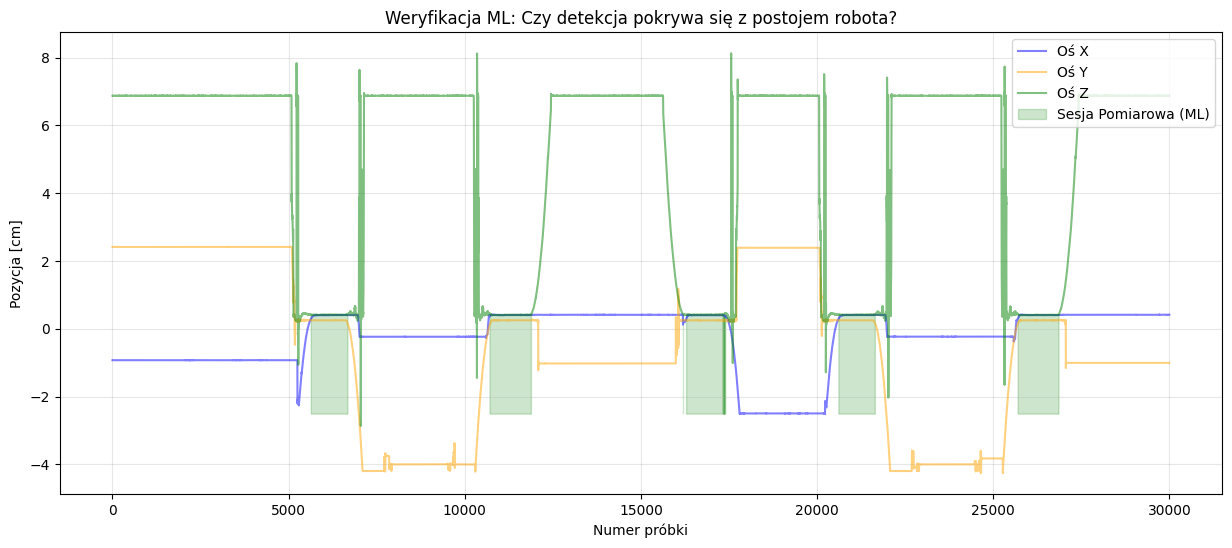

In [ ]:
start_p, end_p = 0, 30000
subset = df.iloc[start_p:end_p]

plt.figure(figsize=(15, 6))
plt.plot(subset.index, subset['x'], label='Oś X', color='blue', alpha=0.5)
plt.plot(subset.index, subset['y'], label='Oś Y', color='orange', alpha=0.5)
plt.plot(subset.index, subset['z'], label='Oś Z', color='green', alpha=0.5)
is_pp_subset = subset['is_near_pp']
plt.fill_between(subset.index, subset['x'].min(), subset['x'].max(), 
                 where=is_pp_subset, color='green', alpha=0.2, label='Sesja Pomiarowa (ML)')

plt.title("Weryfikacja ML: Czy detekcja pokrywa się z postojem robota?")
plt.xlabel("Numer próbki")
plt.ylabel("Pozycja [cm]")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
dist_to_center = np.sqrt(((df[['x', 'y', 'z']] - ml_center)**2).sum(axis=1))
is_in_pp = dist_to_center < 0.1 
session_id = (is_in_pp != is_in_pp.shift()).cumsum()
pp_sessions = df[is_in_pp].groupby(session_id).filter(lambda x: len(x) > 750)

final_results = []
for sid, group in pp_sessions.groupby(session_id):
    stable_data = group.iloc[100:-100] 
    final_results.append({
        'session_no': len(final_results) + 1,
        'start_idx': stable_data.index[0],
        'end_idx': stable_data.index[-1],
        'x_avg': stable_data['x'].mean(),
        'y_avg': stable_data['y'].mean(),
        'z_avg': stable_data['z'].mean(),
        'samples': len(stable_data)
    })

sessions_df = pd.DataFrame(final_results)

print(f"--- RAPORT DETEKCJI ---")
print(f"Oczekiwane wizyty: 300")
print(f"Wykryte wizyty:    {len(sessions_df)}")
print(f"-----------------------")

print(sessions_df.head())


--- RAPORT DETEKCJI ---
Oczekiwane wizyty: 300
Wykryte wizyty:    300
-----------------------
   session_no  start_idx  end_idx     x_avg     y_avg     z_avg  samples
0           1       5708     6574  0.404083  0.251337  0.410239      867
1           2      10824    11814  0.407423  0.251838  0.408824      991
2           3      16367    17364  0.403113  0.249658  0.412927      998
3           4      20685    21548  0.405908  0.251740  0.410589      864
4           5      25795    26791  0.406984  0.251355  0.408415      997
